# Getting Started with a Reflection Spectrum of Jupiter

Hajime Kawahara 3/16 (2025)

In this tutorial, we analyze the high-resolution near-infrared reflection spectrum of Jupiter. 
This is a simplified version of the analysis performed in [exojaxample_jupiter](https://github.com/HajimeKawahara/exojaxample_jupiter).

The spectrum to be analyzed is as follows. The absorption lines observed in the spectrum are primarily due to methane. While a comprehensive line database for methane in the visible range is still lacking (see [here](https://secondearths.sakura.ne.jp/exojax/tutorials/jupiters/Jupiter_Hires_Modeling.html)), the near-infrared range allows for a reasonable explanation of the observed data. Additionally, since this is a reflection spectrum, the original solar spectrum must also be taken into account.

/home/kawahara/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


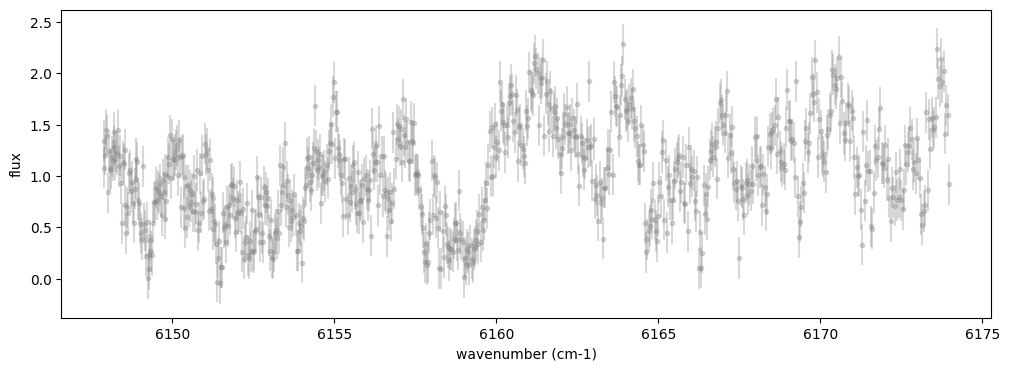

In [1]:
from exojax.test.emulate_spec import sample_reflection_spectrum
import matplotlib.pyplot as plt

nu_obs, flux, err_flux = sample_reflection_spectrum()

fig = plt.figure(figsize=(12,4))
plt.errorbar(nu_obs,flux,yerr=err_flux,fmt=".",color="gray", alpha=0.3)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux")
plt.show()

I found very good one: High-resolution solar spectrum taken from Meftar et al. (2023). Get the data.

- 10.21413/SOLAR-HRS-DATASET.V1.1_LATMOS
- http://doi.latmos.ipsl.fr/DOI_SOLAR_HRS.v1.1.html
- http://bdap.ipsl.fr/voscat_en/solarspectra.html


In [2]:
from exojax.spec.unitconvert import wav2nu
import pandas as pd
filename = "/home/kawahara/solar-hrs/Spectre_HR_LATMOS_Meftah_V1.txt"
dat = pd.read_csv(filename, names=("wav","flux"), comment=";", delimiter="\t")
dat["wav"] = dat["wav"]*10

wav_solar = dat["wav"][::-1]
solspec = dat["flux"][::-1]
nus_solar = wav2nu(wav_solar,unit="AA")

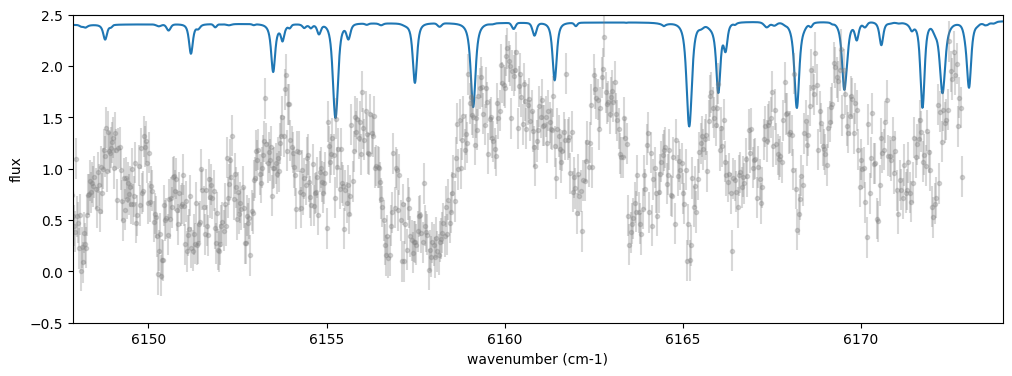

In [3]:
from exojax.utils.constants import c
vrv = -55 #km/s
fig = plt.figure(figsize=(12,4))
plt.plot(nus_solar,solspec*10)
plt.errorbar(nu_obs*(1 + vrv/c),flux,yerr=err_flux,fmt=".",color="gray", alpha=0.3)
plt.xlim(nu_obs[0],nu_obs[-1])
plt.ylim(-0.5,2.5)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux")
plt.show()

Now, we will use `ArtReflectPure` for the radiative transfer of reflected light. 

In [4]:
import numpy as np
from exojax.utils.grids import wavenumber_grid
from exojax.spec.atmrt import ArtReflectPure

nus, wav, res = wavenumber_grid(
    np.min(nu_obs) - 5.0, np.max(nu_obs) + 5.0, 10000, xsmode="premodit", unit="cm-1"
)

art = ArtReflectPure(
        nu_grid=nus, pressure_btm=3.0e1, pressure_top=1.0e-3, nlayer=200
    )

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
Your wavelength grid is in ***  descending  *** order
The wavenumber grid is in ascending order by definition.
Please be careful when you use the wavelength grid.


/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:13: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


Now, let's use the temperature-pressure (T-P) profile of Jupiter obtained by the Galileo probe. Please install [jovispec](https://github.com/HajimeKawahara/jovispec).

In [17]:
from jovispec.tpio import read_tpprofile_jupiter
dat = read_tpprofile_jupiter()
torig = dat["Temperature (K)"]
porig = dat["Pressure (bar)"]

Let's interpolate the temperature grid to match the pressure grid of `art`. For simplicity, we will assume an isothermal atmosphere in the upper layers.

In [23]:
Tarr_np = np.interp(art.pressure, porig, torig)
i = np.argmin(Tarr_np)
Tarr_np[0:i] = Tarr_np[i]

# acutually, this just convert Tarr_np to jnp.array
Tarr = art.custom_temperature(Tarr_np)

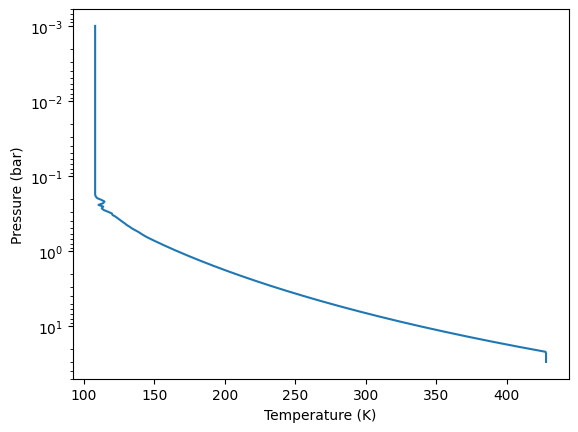

In [22]:
plt.plot(Tarr,art.pressure)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (bar)")
plt.show()

Set the mean molecular weight and gravity.

In [24]:
from exojax.utils.astrofunc import gravity_jupiter
mu = 2.22  # mean molecular weight NASA Jupiter fact sheet
gravity = gravity_jupiter(1.0, 1.0)

In Jupiter's atmosphere, the primary reflectors of sunlight are ammonia clouds. Therefore, we retrieve ammonia from the `PdbCloud` database. As the cloud model, we use the [Ackerman & Marley (AM)-like model](Ackerman_and_Marley_cloud_model.html), which can be accessed via `AmpAmcloud` from `atmphys`. 

Whether a simple gray cloud model would suffice is worth considering. Using an overly complex model for the data can obscure the assumptions being made. However, since the cloud composition and the T-P profile of Jupiter are well understood, using an AM model should not be excessive.

In [ ]:
from exojax.spec.pardb import PdbCloud
from exojax.atm.atmphys import AmpAmcloud


pdb_nh3 = PdbCloud("NH3")
amp_nh3 = AmpAmcloud(pdb_nh3, bkgatm="H2")
amp_nh3.check_temperature_range(Tarr)

.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  .database/particulates/virga/NH3.refrind
Miegrid file exists: .database/particulates/virga/miegrid_lognorm_NH3.mg.npz


/home/kawahara/exojax/src/exojax/atm/atmphys.py:54: UserWarning: min temperature 107.99141693115234 K is smaller than min(vfactor t range) 179.10000610351562 K
  warnings.warn(


We calculate the condensate substance density of cloud particles. Based on Jupiter's observations, we assume an ammonia abundance three times the solar composition. Finally, we define the mass mixing ratio of ammonia at the cloud base.

In [26]:
from exojax.utils.zsol import nsol
from exojax.atm.atmconvert import vmr_to_mmr
from exojax.spec.molinfo import molmass_isotope

# condensate substance density
rhoc = pdb_nh3.condensate_substance_density  # g/cc
n = nsol("AG89")
abundance_nh3 = 3.0 * n["N"]  # x 3 solar abundance
molmass_nh3 = molmass_isotope("NH3", db_HIT=False)
MMRbase_nh3 = vmr_to_mmr(abundance_nh3, molmass_nh3, mu)

Database for solar abundance =  AG89
Anders E. & Grevesse N. (1989, Geochimica et Cosmochimica Acta 53, 197) (Photospheric, using Table 2)


We assume that cloud scattering follows Mie scattering. The `opa` for Mie scattering is `OpaMie`.

In [27]:
from exojax.spec.opacont import OpaMie

opa_nh3 = OpaMie(pdb_nh3, nus)

In [30]:
from exojax.spec.api import MdbHitemp
mdb_reduced = MdbHitemp("CH4", nurange=[nus[0], nus[-1]], isotope=1, elower_max=3300.0)

radis engine =  vaex
Enter HITRAN password: 

error: (25, 'Inappropriate ioctl for device')

In [ ]:
from exojax.spec.opacalc import OpaPremodit
